In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

from tempfile import mkdtemp
from shutil import rmtree
from joblib import Memory

In [105]:
from scipy import stats
from scipy.stats import uniform


# sklearn preproc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, chi2


In [106]:
data = pd.read_csv('../raw_data/dataset.csv',sep=';')
data = data.copy()
data.head()

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,...,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,...,1,1,2,2,0,0,0,49014,13.181389,NaN
2,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,2,2,0,0,0,124839,11.561944,1.0
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,324676,15.751111,1.0
4,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,7100,12.698611,NaN


In [107]:
data.shape

(99976, 43)

## 1. Preprocessing workflow 

## Preprocessing
### Pipeline 

### a) Ordinal Encoding 
#### Explanation - [Ordinal Encoding or One-Hot-Encoding](https://stackoverflow.com/questions/69052776/ordinal-encoding-or-one-hot-encoding)

In [108]:
# removing the missing values of the target and these raws from the dataset
###
# removing coulumn "uuid" from the dataset
data_id = data['uuid']
#_ = data.reset_index()
#data = _.drop(['uuid'], axis=1)
data.drop(['uuid'], axis=1, inplace=True)
# setting target and removing the "default" from dataset
target = data['default'].dropna()
data.dropna(subset=['default'], axis=0, inplace=True)
data.drop(['default'], axis=1, inplace=True)
# isna and isnull were not recognizing "nan" 
data = data.replace('nan', np.NaN)


In [109]:
 # converting these columns to "object" type
list_float_to_obj = ["worst_status_active_inv", "account_status","account_worst_status_0_3m",
                     "account_worst_status_12_24m", "account_worst_status_3_6m", "account_worst_status_6_12m",
                     "status_last_archived_0_24m", "status_2nd_last_archived_0_24m","status_3rd_last_archived_0_24m",
                     "status_max_archived_0_6_months","status_max_archived_0_12_months","status_max_archived_0_24_months",
                     "has_paid"]

_ = [data.__setitem__(feature, data[feature].astype("object")) for feature in list_float_to_obj]


In [110]:
feat_ordinal_dict = {
    # considers "missing" as "neutral"
    "account_status": ['missing', 1.0, 2.0, 3.0, 4.0],
    "account_worst_status_0_3m": ['missing', 1.0, 2.0, 3.0, 4.0],
    "account_worst_status_12_24m": ['missing', 1.0, 2.0, 3.0, 4.0],
    "account_worst_status_3_6m": ['missing', 1.0, 2.0, 3.0, 4.0],
    "account_worst_status_6_12m": ['missing', 1.0, 2.0, 3.0, 4.0],
    "has_paid": ['True', 'False'],
    "status_last_archived_0_24m": [1, 0, 2, 3, 5],
    "status_2nd_last_archived_0_24m": [1, 0, 2, 3, 5],
    "status_3rd_last_archived_0_24m": [1, 0, 2, 3, 5],
    "status_max_archived_0_6_months": [1, 0, 2, 3],
    "status_max_archived_0_12_months": [1, 2, 0, 3, 5],
    "status_max_archived_0_24_months": [1, 2, 0, 3, 5],
    "worst_status_active_inv": ['missing', 1.0, 2.0, 3.0]
}

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]


In [111]:
# renaming the columns to have less characteres 
data = data.rename(columns={'merchant_category': 'cat', 'merchant_group': 'grp', 'name_in_email': 'email'})

In [113]:
# UserWarning: Persisting input arguments took 3.76s to run.
# If this happens often in your code, it can cause performance problems 
# (results will be correct in all cases). 
# The reason for this is probably some large input arguments for a wrapped
# function (e.g. large strings).
# THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
# example so that they can fix the problem.
# X, fitted_transformer = fit_transform_one_cached(
# to surpass the above warning message we're simplifying the names of the categories.

simplifying_dict = {'Dietary supplements': 'diet suppls', 
                    'Books & Magazines':'read prod',
                    'Diversified entertainment': 'Diver entmt',
                    'Electronic equipment & Related accessories':'elect eqt & related accs',
                    'Concept stores & Miscellaneous': 'concept stores & misc', 
                    'Youthful Shoes & Clothing': 'youth shoes & cloth',
                    'General Shoes & Clothing': 'gen shoes & cloth', 
                    'Prints & Photos': 'prt & pic',
                    'Diversified children products':'diver children prods', 
                    'Pet supplies': 'pet sups',
                    'Diversified Home & Garden products': 'diver home & gdn prod', 
                    'Sports gear & Outdoor':'sports gear & Outa',
                    'Diversified electronics':'diver elect', 
                    'Diversified Jewelry & Accessories':'diver jewelry & accs',
                    'Travel services':'travel serv', 
                    'Prescription optics': 'rx optics',
                    'Pharmaceutical products':'pharmaceutical prod', 
                    'Dating services': 'dating serv',
                    'Diversified Health & Beauty products':'diver health & bt prod', 
                    'Automotive Parts & Accessories': 'auto parts & accs', 
                    'Jewelry & Watches':'jewelry & watches',
                    'Digital services': 'digit serv', 
                    'Decoration & Art': 'decor & art',
                    'Children Clothes & Nurturing products': 'children prod',
                    'Hobby articles': 'hobby art.',
                    'Personal care & Body improvement': 'personal care prod', 
                    'Diversified erotic material': 'diver erotic mater',
                    'Video Games & Related accessories': 'videogGames & accs',
                    'Tools & Home improvement':'home tool improv',
                    'Household electronics (whitegoods/appliances)': 'household elect',
                    'Adult Shoes & Clothing': 'adult shoes & cloth',
                    'Erotic Clothing & Accessories':'erotic cloth & accs',
                    'Costumes & Party supplies':'costumes & party sups',
                    'Musical Instruments & Equipment': 'musical instruments & eqt',
                    'Wine, Beer & Liquor': 'alcohol drinks',
                    'Office machines & Related accessories (excl. computers)':'office accs',
                    }

data['cat'] = data['cat'].replace({k: v for k, v in simplifying_dict.items() if k in set(data['cat'])})

# checking 
# data.select_dtypes(include='object').nunique()

### b) Statistical Feature Selection

In [114]:
# Defining Numercal features
feat_numerical = sorted(data.select_dtypes(include=["int64", "float64"]).columns)
# Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
feat_nominal = sorted(list(set(data.columns) - set(feat_numerical) - set(feat_ordinal)))

#### Pipeline ######
preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

# Pipeline final version  - prepoc 
encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than "missing"
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")


# preproc_selector = SelectPercentile(
#     mutual_info_regression,
#     percentile=50, # keep only xx% of all features )
# )

preproc_selector = SelectPercentile(
    chi2,
    percentile=40, # keep only xx% of all features )
)


# preproc_selector = VarianceThreshold(0)

preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x132bbb9a0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordi...
                                                   'status_max_archived_0_24_months',
                                                   'status_max_archived_0_6_months',
                                                   'worst_status_active_inv']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cat', 'email', 'grp'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=40,
                                  score_func=<function chi2 at 0x128e82ee0>))])

In [115]:
# random_state=42 we want to compare the performance of diferent models
X_train, X_test, y_train, y_test = train_test_split(data,target,test_size=0.30, random_state=42)


In [143]:

# Get column names after preprocessing
column_names = preproc.fit(X_train,y_train).get_feature_names_out()
# Create new DataFrame with transformed data and column names
X_train_preproc = pd.DataFrame(preproc.transform(X_train), columns=column_names, dtype=np.float16)


In [116]:
# This code is setting up a cache directory to store the results of the preprocessing step of a pipeline.
# Caching can improve the performance of the pipeline by avoiding repeated computation of the same preprocessing step. 
# The cache directory is created using the mkdtemp function from the tempfile module, 
# and the directory path is stored in the variable cachedir. 
# The directory will be automatically deleted after use by the rmtree function from the shutil module. 
# The use of caching can be controlled by setting the memory parameter of the Pipeline object to cachedir.
allow_grid_searching = False # use True to activate girdsearch in the notebook cells below
# Cache the preprocessing step of the pipeline
cachedir = mkdtemp()


In [ ]:
# para avançar: ver rmse and rmse_neg. é valido para o meu caso, visto que a tenho um classification pred
# obejctivo ver todas os passos aplicar e ver os resultados e APRENDER!

### 2.2 Model Iteration ♻

#### a) Model KNN

In [ ]:
# It has been chosen this "roc_auc" (Area Under the Curve) scoring metric over other once is general metric, 
# showing how well the model is able to distinguish between two classes across all threshold

In [16]:
# explanation
###### model #####
model_knn2 = KNeighborsClassifier()
pipe_knn2 = make_pipeline(preproc, model_knn2, memory=cachedir)
scores_knn2 = cross_val_score(pipe_knn2, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1)
scores_knn2.mean()
# result before removing the features of the list of features_to_remove
######### 0.64176513305926 ##########

KeyboardInterrupt: 

As one can see we do have features with a high numbers of unique values


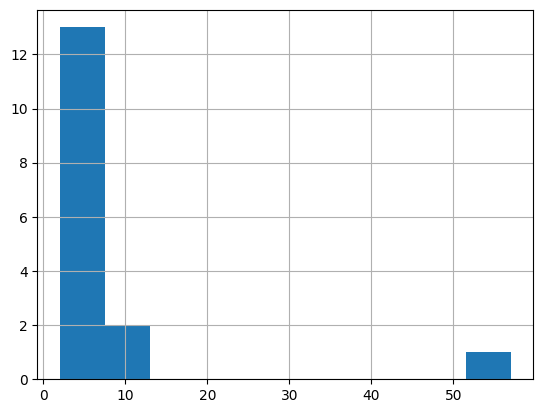

In [117]:
# The above code have got the following  warning message: 
    # UserWarning: Persisting input arguments took 2.21s to run.
    # If this happens often in your code, it can cause performance problems 
    # (results will be correct in all cases). 
    # The reason for this is probably some large input arguments for a wrapped
    #  function (e.g. large strings).
    # THIS IS A JOBLIB ISSUE.
# To tackle this issue we're foreseeing the possibility of removing from the dataset all categoric features with 7 unique values or more.
feat_categorical_nunique = data.select_dtypes(include='object').nunique()
feat_categorical_nunique.hist();
print("As one can see we do have features with a high numbers of unique values")
# categorical features 
feat_categorical_small = list(feat_categorical_nunique[feat_categorical_nunique > 7].index)

In [15]:
feat_categorical_small


['cat', 'grp', 'email']

#### b) Model Trees

In [16]:
# max_depth: This parameter sets the maximum depth of each decision tree in the ensemble. 
# A deeper tree can learn more complex relationships between features, but can also lead to overfitting.
# min_samples_leaf: This parameter sets the minimum number of samples required to be at a leaf node of each decision tree in the ensemble.
# A higher value of this parameter can help prevent overfitting by ensuring that each leaf contains a minimum number of samples.
##### Note ##### Note ##### Note #####
# In decision trees, a leaf node is a node that has no child nodes. 
# It represents a decision or prediction that is made by the tree for a particular subset of the data.
# When a decision tree is trained, it recursively splits the data into subsets based on the values of the features, 
# until it reaches a leaf node. At each non-leaf node, the tree makes a decision based on the values of one of the features, 
# and the data is split into two or more subsets based on the decision. This process continues until the tree reaches a stopping criterion, 
# such as a maximum depth or a minimum number of samples per leaf.
# for ou case is max_depth=50 and min_samples_leaf=20, respectively. 
###########
# start the timer
start_time = time.time()

###### model #####
model_trees = DecisionTreeClassifier(max_depth=50, min_samples_leaf=20)
pipe_trees = make_pipeline(preproc, model_trees, memory=Memory(cachedir, verbose=0, mmap_mode='r', bytes_limit=10**9))
# just changed memory parameter to avoid either joblib warning and decrease running time
score_trees = cross_val_score(pipe_trees, X_train, y_train, cv=5, scoring="roc_auc",  n_jobs=-1)
score_trees.mean()
# before removing the feature that are not significant for our analysis 
# this model obtained this result ##### 0.7257535924274194 #####
# stop the timer
#########
end_time = time.time()
# calculate the running time
running_time = end_time - start_time
print(f"Running time: {running_time:.2f} seconds")


KeyboardInterrupt: 

#### c) Model Random Forest

In [17]:
# It is another type of supervised machine learning algorithm, but it is used for classification tasks. 
# It is an ensemble method that combines multiple decision trees to create a strong predictive model.
###### model #####
model_randforest = RandomForestClassifier(max_depth=50,min_samples_leaf=20)
pipe_randforest = make_pipeline(preproc, model_randforest, memory=Memory(cachedir, verbose=0, mmap_mode='r', bytes_limit=10**9))
score_randforest = cross_val_score(pipe_randforest, X_train, y_train, cv=5, scoring="roc_auc")
print(score_randforest.std())
score_randforest.mean()
# result before simplifying teh categories names
# 0.9059380394136876

/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 2.03s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 1.99s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the jobli

0.00414067735471941


0.9059380394136876

#### d) Model Boosted Trees

In [118]:
# The AdaBoostClassifier is a type of ensemble learning algorithm that combines multiple weak classifiers to create a strong classifier. 
# It works by training a series of base estimators, which are typically simple models with low predictive power, 
# and then iteratively adjusting the weights of misclassified samples to focus on the samples that are most difficult to classify
# we're using the DecisionTreeClassifier as its base estimator, which means that each weak classifier in the ensemble is a decision tree.
# The max_depth=None parameter of the DecisionTreeClassifier means that there is no limit on the maximum depth of the decision trees, 
# so they can grow as deep as necessary to fit the training data.
# Attention!! I am afraid this can lead to a huge running time. IF it does os let's place 30. 
####
# start the timer
start_time = time.time()
###### model #####
model_ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=None))
pipe_ada = make_pipeline(preproc, model_ada, memory=Memory(cachedir, verbose=0, mmap_mode='r', bytes_limit=10**9))
score_ada = cross_val_score(pipe_ada, X_train, y_train, cv=5, scoring="roc_auc")
print(score_ada.std())
score_ada.mean()
end_time = time.time()
# calculate the running time
running_time = end_time - start_time
print(f"Running time: {running_time:.2f} seconds")

/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 2.00s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 2.00s to run.
If this happens often in your code, it can c

0.026903210915137702
Running time: 1668.23 seconds


In [119]:
score_ada.mean()

0.789285079095549

#### e) Model Gradient Boost Classifier 

In [120]:
# supervised machine learning algorithm that is commonly used for classification tasks
# loss: loss function can have a significant impact on the performance of the model. 
# Default loss = "log_loss". We'll hyperparameters to find the best model for our problem.  
# by default learning_rate = 0.01 Setting a lower learning_rate can help prevent overfitting 
# by slowing down the learning process and preventing the model from becoming too complex
# but also can lead to slower convergence. 
# n_estimators: This parameter sets the number of decision trees that will be created in the ensemble
###### model #####
model_gb = GradientBoostingClassifier(n_estimators=100, verbose=0)
pipe_gb = make_pipeline(preproc, model_gb, memory=Memory(cachedir, verbose=0, mmap_mode='r', bytes_limit=10**9))
score_gb = cross_val_score(pipe_gb, X_train, y_train, cv=5, scoring="roc_auc")
print(score_gb.std())
score_gb.mean()

0.005385317932282922


0.9007369896483993

In [1]:
# it's important to know what are the params we can use 
# pipe_gb.get_params()

#### f) Model SVC

In [ ]:
# explanation
###### model #####
model_SVC = SVC()
pipe_svc = make_pipeline(preproc, model_SVC, memory=Memory(cachedir, verbose=0, mmap_mode='r', bytes_limit=10**9))

In [121]:
# this is important to 
# preproc.get_params()
model_SVC = SVC()
pipe_svc = make_pipeline(preproc, model_SVC, memory=Memory(cachedir, verbose=0, mmap_mode='r', bytes_limit=10**9))
# Random search 
search = RandomizedSearchCV(
    pipe_svc, 
    param_distributions ={
        'svc__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'svc__C': uniform(0.1,10)},
    cv=5,
    n_iter = 1,
    scoring="roc_auc")

search.fit(X_train,y_train)

pipe_svc_tuned = search.best_estimator_
pipe_svc_tuned
# for this model to take at it:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier

/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 2.49s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


Pipeline(memory=Memory(location=/var/folders/79/g5hy_j1x4c52kc540l6hhyd00000gn/T/tmpmyrq6e50/joblib),
         steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('knnimputer',
                                                                                    KNNImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x12...
                                                                    'status_max_archived_0_6_months',
                                                                    'worst_status_active_inv']),
                                                                  ('pipeline-3',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['cat',
                                                                    'email',
                                                                    'grp'])])),
                                 ('selectpercentile',
                                  SelectPercentile(percentile=40,
                                                   score_func=<function chi2 at 0x128e82ee0>))])),
                ('svc', SVC(C=5.740754985858537, kernel='sigmoid'))])

In [122]:
scores_svc = cross_val_score(pipe_svc_tuned, X_train,y_train,cv=5, scoring="roc_auc")
scores_svc.mean()

0.5352783878937177

#### g) Model Gradient Boost Classifier - fine tuning - boosting!

Fitting 5 folds for each of 6 candidates, totalling 30 fits
      Iter       Train Loss   Remaining Time 
         1           0.2276            5.22s
         2           0.2122            4.99s
         3           0.2022            4.72s
         4           0.1936            4.55s
         5           0.1912            4.50s
         6           0.1844            4.42s
         7           0.1806            4.38s
         8           0.1778            4.29s
         9           0.1732            4.22s
        10           0.1706            4.15s
        20           0.1529            3.49s
        30           0.1462            2.90s
        40           0.1420            2.29s
        50           0.1374            1.71s
        60           0.1349            1.12s
        70           0.1325            0.53s
[CV] END gradientboostingclassifier__learning_rate=0.2752608425577162, gradientboostingclassifier__loss=exponential, gradientboostingclassifier__max_features=37, gradientboos

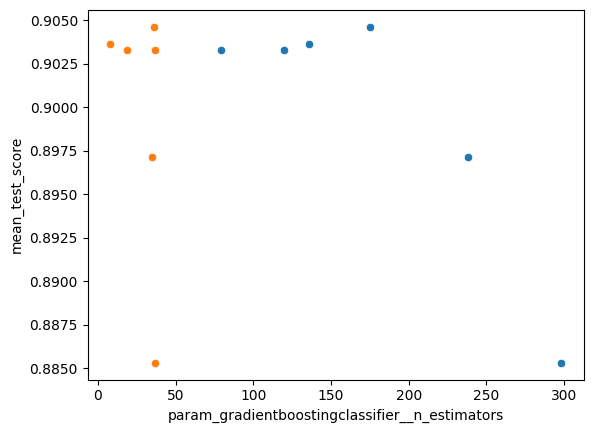

In [216]:
allow_grid_searching = True
nr_features = len(column_names)
if allow_grid_searching:
    grid = {
         'gradientboostingclassifier__n_estimators': stats.randint(50,300),
         'gradientboostingclassifier__learning_rate':stats.uniform(0.05,0.3),
         'gradientboostingclassifier__loss': ['log_loss','exponential'],
    #    'gradientboostingclassifier__max_depth': stats.randint(3,5),    
    #    'gradientboostingclassifier__min_samples_split':stats.randint(2,10),
    #    'gradientboostingclassifier__subsample':[0.95, 1], # 1 default
         'gradientboostingclassifier__max_features':stats.randint(1,nr_features), # default None, i.e = n_features
    }

    search_gb = RandomizedSearchCV(pipe_gb, grid, scoring="roc_auc", n_iter=6, cv=5, n_jobs=1, verbose=2,)

    # Fit data to Grid Search
    search_gb.fit(X_train, y_train);
    print(search_gb.best_params_)
    search_gb.best_score_
    pipe_gradboost_tuned = search_gb.best_estimator_

    # Plot results of gridsearch
    df_cv_results_ = pd.DataFrame(search_gb.cv_results_)
    sns.scatterplot(x="param_gradientboostingclassifier__n_estimators", y='mean_test_score', data=df_cv_results_)
    sns.scatterplot(x="param_gradientboostingclassifier__max_features", y='mean_test_score', data=df_cv_results_)
    #sns.scatterplot(x="gradientboostingregressor__learning_rate", y='mean_test_score', data=df_cv_results_)
    #sns.scatterplot(x="gradientboostingclassifier__loss", y='mean_test_score', data=df_cv_results_)
    

In [226]:
df_cv_results_['mean_test_score'].sort_values(ascending=False)

5    0.904612
3    0.903642
0    0.903288
2    0.903275
4    0.897120
1    0.885322
Name: mean_test_score, dtype: float64

#### h) Model random Forest Classifier - boosting!

In [256]:
allow_grid_searching = True
nr_features = len(column_names)
# to know what are the params we can use and their names we can run this code: 
# pipe_randforest.get_params() 
if allow_grid_searching:
    grid = {
         'randomforestclassifier__n_estimators': stats.randint(50,300),
         'randomforestclassifier__min_samples_leaf':stats.randint(10,50),
         'randomforestclassifier__max_depth': stats.randint(30,100),    
    #    'randomforestclassifier__min_samples_split':stats.randint(2,10),
    #    'randomforestclassifier__subsample':[0.95, 1], # 1 default
         'randomforestclassifier__max_features':stats.randint(1,nr_features), # default None, i.e = n_features
    }

    search_randforest = RandomizedSearchCV(pipe_randforest, grid, scoring="roc_auc", n_iter=6, cv=5, n_jobs=1, verbose=2,)

    # Fit data to Grid Search
    search_randforest.fit(X_train, y_train);
    print(search_randforest.best_params_)
    search_randforest.best_score_
    pipe_randforest_tuned = search_randforest.best_estimator_

    # Plot results of gridsearch
    df_cv_results_ = pd.DataFrame(search_randforest.cv_results_)
    sns.scatterplot(x="param_randomforestclassifier__n_estimators", y='mean_test_score', data=df_cv_results_)
    sns.scatterplot(x="param_randomforestclassifier__max_features", y='mean_test_score', data=df_cv_results_)
    #sns.scatterplot(x="gradientboostingregressor__learning_rate", y='mean_test_score', data=df_cv_results_)
    #sns.scatterplot(x="gradientboostingclassifier__loss", y='mean_test_score', data=df_cv_results_)
    
    #https://towardsdatascience.com/what-is-out-of-bag-oob-score-in-random-forest-a7fa23d710

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 2.05s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV] END randomforestclassifier__max_depth=87, randomforestclassifier__max_features=33, randomforestclassifier__min_samples_leaf=12, randomforestclassifier__n_estimators=62; total time= 5.5min


/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 1.99s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV] END randomforestclassifier__max_depth=87, randomforestclassifier__max_features=33, randomforestclassifier__min_samples_leaf=12, randomforestclassifier__n_estimators=62; total time= 5.6min


/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 2.01s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV] END randomforestclassifier__max_depth=87, randomforestclassifier__max_features=33, randomforestclassifier__min_samples_leaf=12, randomforestclassifier__n_estimators=62; total time= 8.8min


/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 2.04s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV] END randomforestclassifier__max_depth=87, randomforestclassifier__max_features=33, randomforestclassifier__min_samples_leaf=12, randomforestclassifier__n_estimators=62; total time= 5.5min


/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 2.03s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


[CV] END randomforestclassifier__max_depth=87, randomforestclassifier__max_features=33, randomforestclassifier__min_samples_leaf=12, randomforestclassifier__n_estimators=62; total time= 5.8min
[CV] END randomforestclassifier__max_depth=95, randomforestclassifier__max_features=41, randomforestclassifier__min_samples_leaf=14, randomforestclassifier__n_estimators=58; total time= 1.2min
[CV] END randomforestclassifier__max_depth=95, randomforestclassifier__max_features=41, randomforestclassifier__min_samples_leaf=14, randomforestclassifier__n_estimators=58; total time= 1.3min
[CV] END randomforestclassifier__max_depth=95, randomforestclassifier__max_features=41, randomforestclassifier__min_samples_leaf=14, randomforestclassifier__n_estimators=58; total time= 1.3min
[CV] END randomforestclassifier__max_depth=95, randomforestclassifier__max_features=41, randomforestclassifier__min_samples_leaf=14, randomforestclassifier__n_estimators=58; total time= 1.2min
[CV] END randomforestclassifier__ma

/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/sklearn/pipeline.py:359: UserWarning: Persisting input arguments took 2.53s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


{'randomforestclassifier__max_depth': 49, 'randomforestclassifier__max_features': 7, 'randomforestclassifier__min_samples_leaf': 21, 'randomforestclassifier__n_estimators': 152}


ValueError: Could not interpret value `param_RandomForestClassifier__n_estimators` for parameter `x`

<AxesSubplot: xlabel='param_randomforestclassifier__n_estimators', ylabel='mean_test_score'>

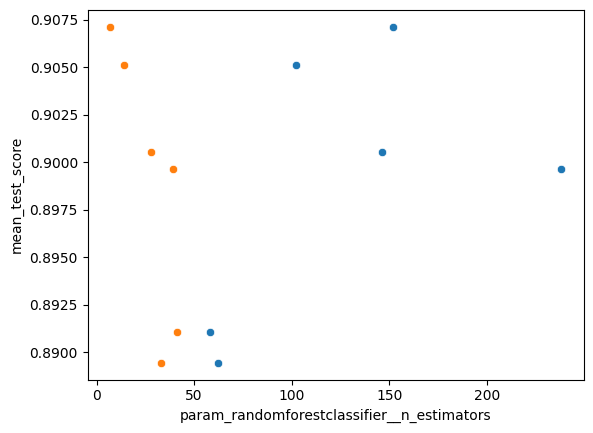

In [257]:
# Plot results of gridsearch
df_cv_results_ = pd.DataFrame(search_randforest.cv_results_)
sns.scatterplot(x="param_randomforestclassifier__n_estimators", y='mean_test_score', data=df_cv_results_)
sns.scatterplot(x="param_randomforestclassifier__max_features", y='mean_test_score', data=df_cv_results_)
#sns.scatterplot(x="gradientboostingregressor__learning_rate", y='mean_test_score', data=df_cv_results_)
#sns.scatterplot(x="gradientboostingclassifier__loss", y='mean_test_score', data=df_cv_results_)

In [258]:
df_cv_results_['mean_test_score'].sort_values(ascending=False)

5    0.907126
3    0.905097
2    0.900552
4    0.899641
1    0.891048
0    0.889449
Name: mean_test_score, dtype: float64

#### i) Stacking

In [305]:
# Define the pipeline with the best hyperparameters
best_params_gb = search_gb.best_params_
best_params_rf = search_randforest.best_params_
gboost = GradientBoostingClassifier(n_estimators=best_params_gb['gradientboostingclassifier__n_estimators'],
                                    learning_rate=best_params_gb['gradientboostingclassifier__learning_rate'],
                                    loss=best_params_gb['gradientboostingclassifier__loss'],
                                    max_features=best_params_gb['gradientboostingclassifier__max_features'])

rforest = RandomForestClassifier(max_depth= best_params_rf['randomforestclassifier__max_depth'],
                                 max_features= best_params_rf['randomforestclassifier__max_features'],
                                 min_samples_leaf=best_params_rf['randomforestclassifier__min_samples_leaf'],
                                 n_estimators= best_params_rf['randomforestclassifier__n_estimators'])

model = StackingClassifier(
    estimators=[("gboost", gboost),("rforest", rforest)],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

pipe_stacking = make_pipeline(preproc, model, memory=Memory(cachedir, verbose=0, mmap_mode='r', bytes_limit=10**9))
score = cross_val_score(pipe_stacking, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1)
print(score.std())
score.mean()

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#examples-using-sklearn-ensemble-stackingclassifier

0.005079862578884062


0.9098998260329054

#### i) XGBoost

In [179]:
from xgboost import XGBClassifier
# https://xgboost.readthedocs.io/en/latest/index.html

In [185]:
# Integrate XGB into Sklearn's pipeline
# Instanciate model
model_xgb = XGBClassifier(max_depth=16, n_estimators=300, learning_rate=0.1, memory=Memory(cachedir, verbose=0, mmap_mode='r', bytes_limit=10**9))
pipe_xgb = make_pipeline(preproc, model_xgb)
score_xgb = cross_val_score(pipe_xgb,X_train,y_train,cv=5,scoring="roc_auc",n_jobs=-1)
print(score_xgb.std())
score_xgb.mean()


[22:11:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "memory" } are not used.

[22:12:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "memory" } are not used.

[22:39:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "memory" } are not used.

[22:48:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "memory" } are not used.

[22:49:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "memory" } are not used.

0.0037872108719135397


0.888355138303494

/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/emilioaguiar/.pyenv/versions/3.8.12/envs/klarna/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[00:06:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "memory" } are not used.

Best Validation Score 0.8267170404760603


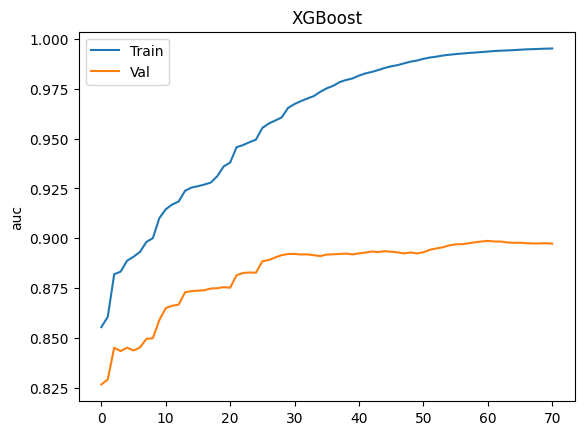

In [189]:
# Option 2: Use XGBoost Library to fit it
# It allows you to use an `early_stopping` criteria with a Train/Val slit
X_train_preproc = preproc.fit_transform(X_train, y_train)
X_test_preproc = preproc.transform(X_test)

model_xgb.fit(X_train_preproc, y_train,
        verbose=False,
        eval_set=[(X_train_preproc, y_train), (X_test_preproc, y_test)],
        eval_metric=["auc"],
        early_stopping_rounds=10)

# retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']["auc"])
x_axis = range(0, epochs)

# plot rmsle loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Val')
ax.legend(); plt.ylabel('auc'); plt.title('XGBoost')

print("Best Validation Score", min(results['validation_1']['auc']))

In [ ]:
# It would have been good to check the results of the XGBoost fined tuned

In [ ]:
# see where is written the code where I create the enviroment for this project 

In [ ]:
# models I'm not using 
# Ridge, Lasso
# Ensemble: VotingClassifier, reading the doc I believe it makes more sense to use StackingClassifier

In [ ]:
# # Clear the cache directory at the end
# rmtree(cachedir)